In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 100.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uni

In [1]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras import layers
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1,EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

import os

Train Set


Loading pituitary: 100%|██████████| 5206/5206 [02:10<00:00, 39.86it/s] 



Test Set


Loading pituitary: 100%|██████████| 186/186 [00:02<00:00, 79.70it/s] 



Image Shape
x train= (15995, 240, 240, 3)
y train= (15995,)
x test= (614, 240, 240, 3)
y test= (614,)

Sample Images


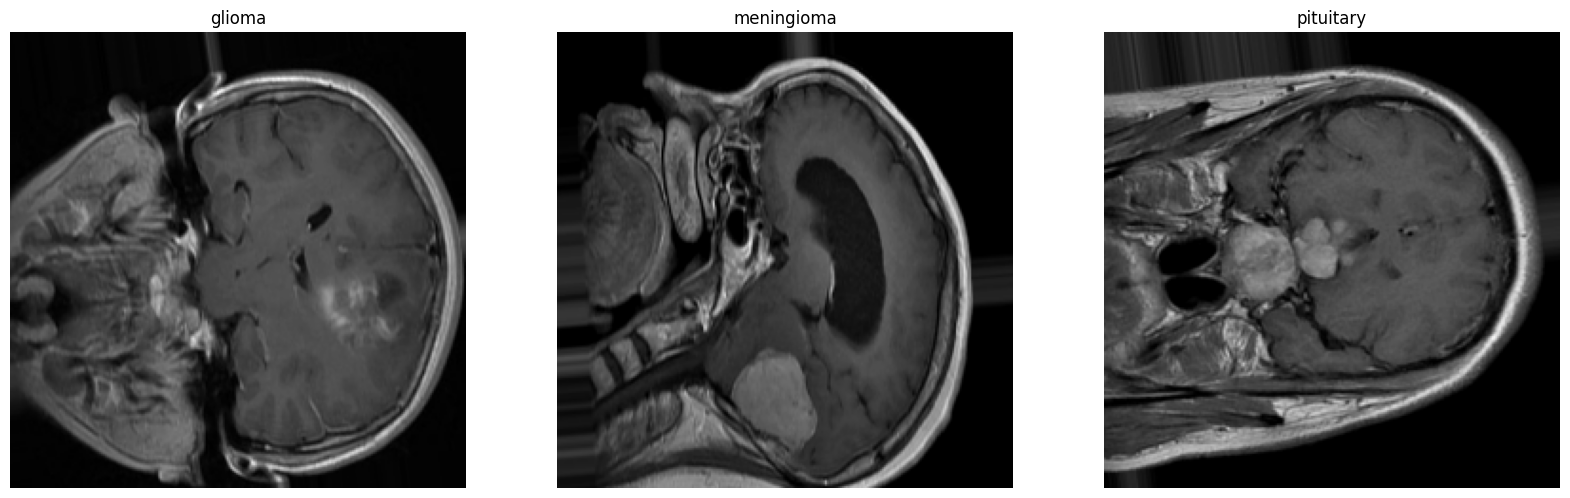

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def load_images(folder_path, labels, image_size):
    images = []
    class_labels = []
    for label in labels:
        label_folder = os.path.join(folder_path, label)
        for image_name in tqdm(os.listdir(label_folder), desc=f"Loading {label}"):
            image_path = os.path.join(label_folder, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (image_size, image_size))
            images.append(image)
            class_labels.append(label)
    return np.array(images), np.array(class_labels)

def main():
    base_folder = '/content/drive/MyDrive'
    Aug_folder = 'Aug_images_80_20_Split_With_Brightness'
    split_folder = 'split_images_80_20'

    labels = ['glioma', 'meningioma', 'pituitary']
    image_size = 240

    print("Train Set")
    print("===========")
    train_folder_path = os.path.join(base_folder, Aug_folder)
    X_train, y_train = load_images(train_folder_path, labels, image_size)

    print("\nTest Set")
    print("=========")
    test_folder_path = os.path.join(base_folder, split_folder, 'test')
    X_test, y_test = load_images(test_folder_path, labels, image_size)

    print("\nImage Shape")
    print("===========")
    print("x train=", X_train.shape)
    print("y train=", y_train.shape)
    print("x test=", X_test.shape)
    print("y test=", y_test.shape)

    # Shuffle the dataset
    X_train, y_train = shuffle(X_train, y_train, random_state=100)
    X_test, y_test = shuffle(X_test, y_test, random_state=100)

    return X_train, y_train, X_test, y_test, labels

if __name__ == "__main__":
    X_train, y_train, X_test, y_test, labels = main()


# Plot example images from each class
    print("\nSample Images")
    print("===========")
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            ax[labels.index(i)].imshow(X_train[j])
            ax[labels.index(i)].set_title(i)
            ax[labels.index(i)].axis('off')
            break
        j += 1

plt.show()

# label encoding

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
# Load the EfficientNetB1 model pretrained on ImageNet
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)

# Add custom layers on top of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model1 = Model(inputs=base_model.inputs, outputs=predictions)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define callbacks
tensorboard = TensorBoard(log_dir='logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('effnetb0_Aug_bestv1.h5', monitor='val_accuracy', save_best_only=True)

# Compile the model1
model1.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
# Train the model with the ModelCheckpoint callback
history = model1.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    verbose=1,
    batch_size=32,
    callbacks=[tensorboard, reduce_lr, checkpoint]
)

Epoch 1/40
450/450 [==============================] - 137s 267ms/step - loss: 0.1797 - accuracy: 0.9348 - val_loss: 0.0756 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 2/40
450/450 [==============================] - 118s 263ms/step - loss: 0.0676 - accuracy: 0.9784 - val_loss: 0.0282 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 3/40
450/450 [==============================] - 118s 263ms/step - loss: 0.0457 - accuracy: 0.9853 - val_loss: 0.0693 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 4/40
450/450 [==============================] - 119s 264ms/step - loss: 0.0381 - accuracy: 0.9871 - val_loss: 0.4634 - val_accuracy: 0.8769 - lr: 0.0010
Epoch 5/40
450/450 [==============================] - 119s 265ms/step - loss: 0.0289 - accuracy: 0.9904 - val_loss: 0.0123 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 6/40
450/450 [==============================] - 119s 264ms/step - loss: 0.0299 - accuracy: 0.9901 - val_loss: 0.0602 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 7/40
450/450 [==========================

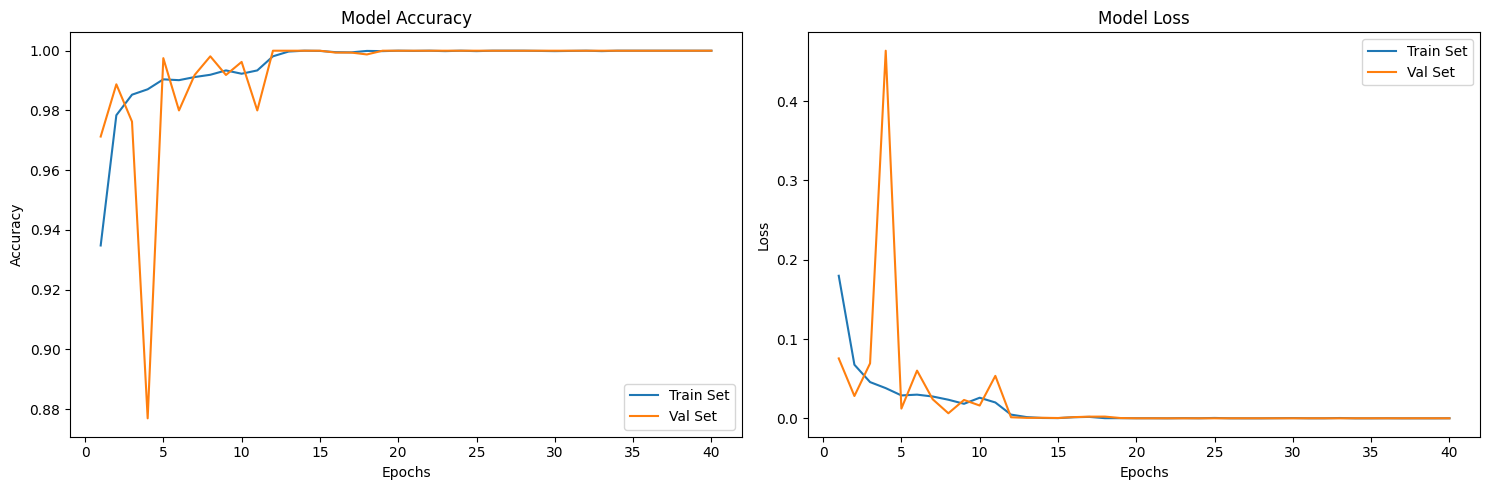

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model1.evaluate(X_test, y_test)

# Print the test accuracy
print("Test Accuracy:", accuracy)

20/20 [==============================] - 3s 81ms/step - loss: 0.0465 - accuracy: 0.9919
Test Accuracy: 0.9918566942214966


# Experiment 2 - EfficientNetB1

In [ ]:
# Load the EfficientNetB1 model pretrained on ImageNet
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

base_model = EfficientNetB1(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)

# Add custom layers on top of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=predictions)

27018416/27018416 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define callbacks
tensorboard = TensorBoard(log_dir='logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('effnetb1_Aug_besv1.h5', monitor='val_accuracy', save_best_only=True)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
# Train the model with the ModelCheckpoint callback
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    verbose=1,
    batch_size=32,
    callbacks=[tensorboard, reduce_lr, checkpoint]
)

Epoch 1/40
450/450 [==============================] - 197s 409ms/step - loss: 0.1997 - accuracy: 0.9294 - val_loss: 0.2456 - val_accuracy: 0.9212 - lr: 0.0010
Epoch 2/40
450/450 [==============================] - 183s 407ms/step - loss: 0.0700 - accuracy: 0.9774 - val_loss: 0.0338 - val_accuracy: 0.9894 - lr: 0.0010
Epoch 3/40
450/450 [==============================] - 183s 407ms/step - loss: 0.0560 - accuracy: 0.9828 - val_loss: 0.0609 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 4/40
450/450 [==============================] - 184s 408ms/step - loss: 0.0325 - accuracy: 0.9896 - val_loss: 0.0374 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 5/40
450/450 [==============================] - 184s 410ms/step - loss: 0.0346 - accuracy: 0.9899 - val_loss: 0.0268 - val_accuracy: 0.9906 - lr: 0.0010
Epoch 6/40
450/450 [==============================] - 185s 410ms/step - loss: 0.0312 - accuracy: 0.9901 - val_loss: 0.0171 - val_accuracy: 0.9944 - lr: 0.0010
Epoch 7/40
450/450 [==========================

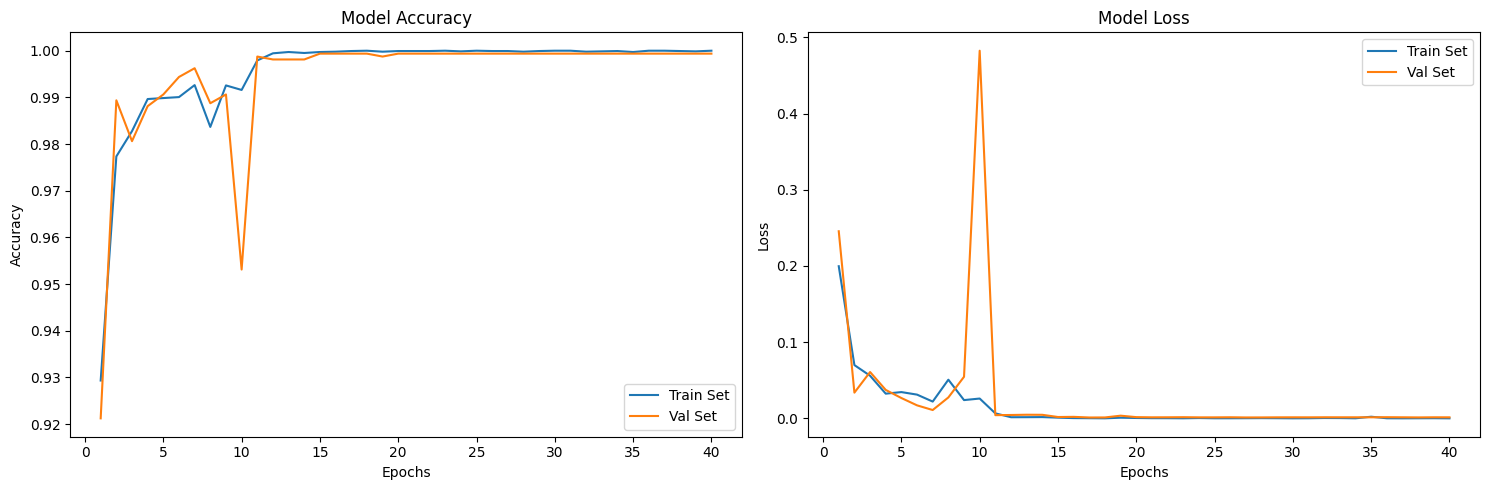

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print("Test Accuracy:", accuracy)

20/20 [==============================] - 4s 90ms/step - loss: 0.0382 - accuracy: 0.9886
Test Accuracy: 0.9885993599891663


# Experiment 3 - EfficientNetB2

In [ ]:
# Load the EfficientNetB2 model pretrained on ImageNet
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

base_model = EfficientNetB2(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)

# Add custom layers on top of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=predictions)

31790344/31790344 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define callbacks
tensorboard = TensorBoard(log_dir='logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('effnetb2_Aug_bestv1.h5', monitor='val_accuracy', save_best_only=True)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
# Train the model with the ModelCheckpoint callback
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    verbose=1,
    batch_size=32,
    callbacks=[tensorboard, reduce_lr, checkpoint]
)

Epoch 1/40
450/450 [==============================] - 210s 432ms/step - loss: 0.1962 - accuracy: 0.9305 - val_loss: 0.1479 - val_accuracy: 0.9456 - lr: 0.0010
Epoch 2/40
450/450 [==============================] - 193s 429ms/step - loss: 0.0683 - accuracy: 0.9780 - val_loss: 0.0372 - val_accuracy: 0.9906 - lr: 0.0010
Epoch 3/40
450/450 [==============================] - 194s 430ms/step - loss: 0.0513 - accuracy: 0.9833 - val_loss: 0.0219 - val_accuracy: 0.9919 - lr: 0.0010
Epoch 4/40
450/450 [==============================] - 193s 429ms/step - loss: 0.0384 - accuracy: 0.9877 - val_loss: 0.2744 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 5/40
450/450 [==============================] - 193s 429ms/step - loss: 0.0422 - accuracy: 0.9875 - val_loss: 0.0783 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 6/40
450/450 [==============================] - 193s 428ms/step - loss: 0.0323 - accuracy: 0.9890 - val_loss: 0.1322 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 7/40
450/450 [==========================

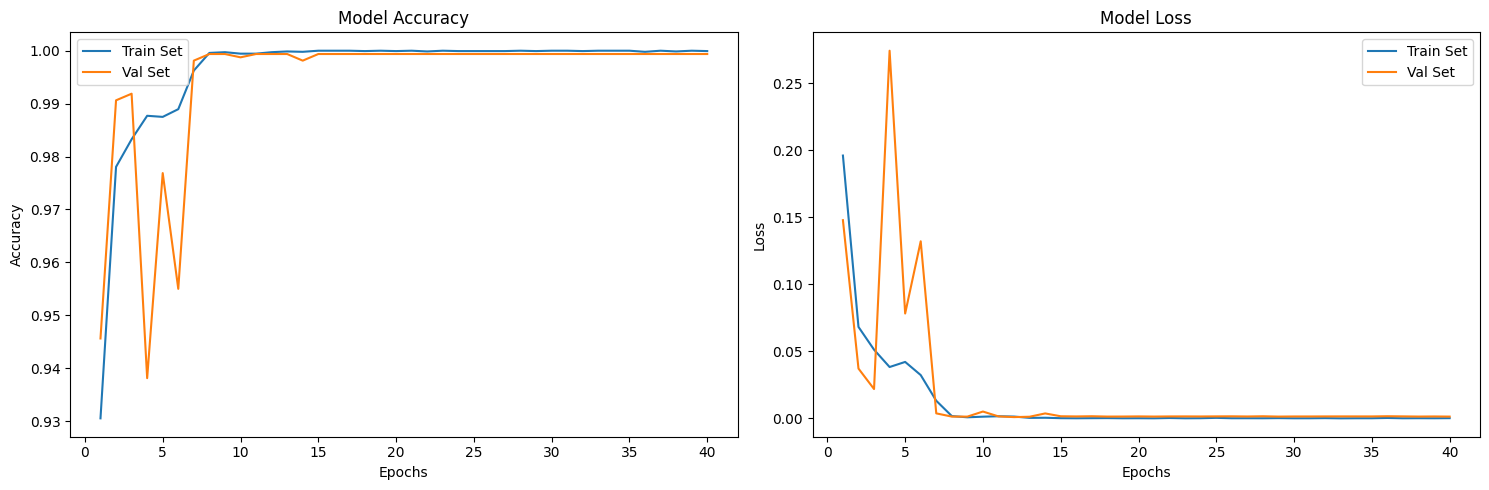

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print("Test Accuracy:", accuracy)

20/20 [==============================] - 4s 108ms/step - loss: 0.0343 - accuracy: 0.9935
Test Accuracy: 0.9934853315353394


# Experiment 4 - EfficientNetB3

In [ ]:
# Load the EfficientNetB3 model pretrained on ImageNet
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

base_model = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)

# Add custom layers on top of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=predictions)

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define callbacks
tensorboard = TensorBoard(log_dir='logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/effnetb3_Aug_bestv1.h5', monitor='val_accuracy', save_best_only=True)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
# Train the model with the ModelCheckpoint callback
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    verbose=1,
    batch_size=32,
    callbacks=[tensorboard, reduce_lr, checkpoint]
)

Epoch 1/40
450/450 [==============================] - 272s 566ms/step - loss: 0.1992 - accuracy: 0.9321 - val_loss: 0.0798 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 2/40
450/450 [==============================] - 250s 554ms/step - loss: 0.0772 - accuracy: 0.9730 - val_loss: 0.1120 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 3/40
450/450 [==============================] - 250s 556ms/step - loss: 0.0540 - accuracy: 0.9812 - val_loss: 0.0941 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/40
450/450 [==============================] - 250s 556ms/step - loss: 0.0472 - accuracy: 0.9849 - val_loss: 0.1079 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 5/40
450/450 [==============================] - 253s 563ms/step - loss: 0.0117 - accuracy: 0.9969 - val_loss: 0.0061 - val_accuracy: 0.9969 - lr: 2.0000e-04
Epoch 6/40
450/450 [==============================] - 253s 562ms/step - loss: 0.0042 - accuracy: 0.9985 - val_loss: 0.0026 - val_accuracy: 0.9987 - lr: 2.0000e-04
Epoch 7/40
450/450 [==================

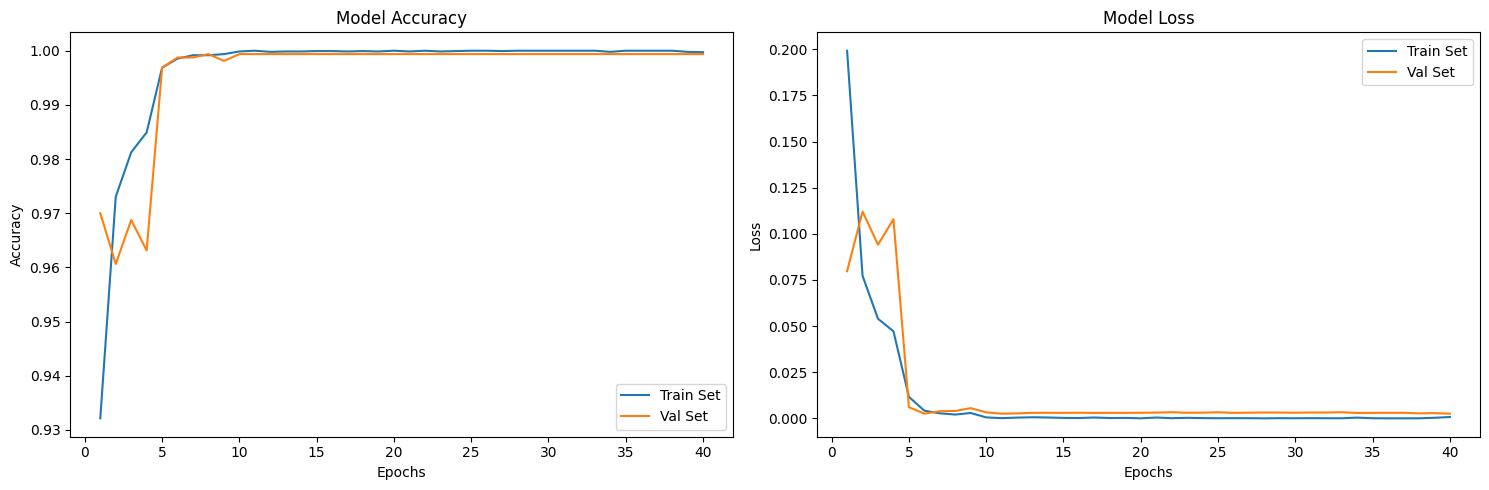

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print("Test Accuracy:", accuracy)

20/20 [==============================] - 5s 140ms/step - loss: 0.0253 - accuracy: 0.9935
Test Accuracy: 0.9934853315353394


# Experiment 5 - EfficientNetB4

In [ ]:
# Load the EfficientNetB4 model pretrained on ImageNet
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

base_model = EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)

# Add custom layers on top of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=predictions)

71686520/71686520 [==============================] - 2s 0us/step


In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define callbacks
tensorboard = TensorBoard(log_dir='logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/effnetb4_Aug_bestv1.h5', monitor='val_accuracy', save_best_only=True)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Train the model with the ModelCheckpoint callback
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    verbose=1,
    batch_size=32,
    callbacks=[tensorboard, reduce_lr, checkpoint]
)

Epoch 1/40
450/450 [==============================] - 361s 753ms/step - loss: 0.1855 - accuracy: 0.9371 - val_loss: 0.1523 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 2/40
450/450 [==============================] - 339s 754ms/step - loss: 0.0723 - accuracy: 0.9758 - val_loss: 0.0345 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 3/40
450/450 [==============================] - 334s 742ms/step - loss: 0.0515 - accuracy: 0.9830 - val_loss: 0.1113 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 4/40
450/450 [==============================] - 334s 743ms/step - loss: 0.0318 - accuracy: 0.9910 - val_loss: 0.2545 - val_accuracy: 0.9287 - lr: 0.0010
Epoch 5/40
450/450 [==============================] - 334s 743ms/step - loss: 0.0539 - accuracy: 0.9839 - val_loss: 0.1725 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 6/40
450/450 [==============================] - 339s 754ms/step - loss: 0.0113 - accuracy: 0.9969 - val_loss: 0.0034 - val_accuracy: 0.9994 - lr: 2.0000e-04
Epoch 7/40
450/450 [======================

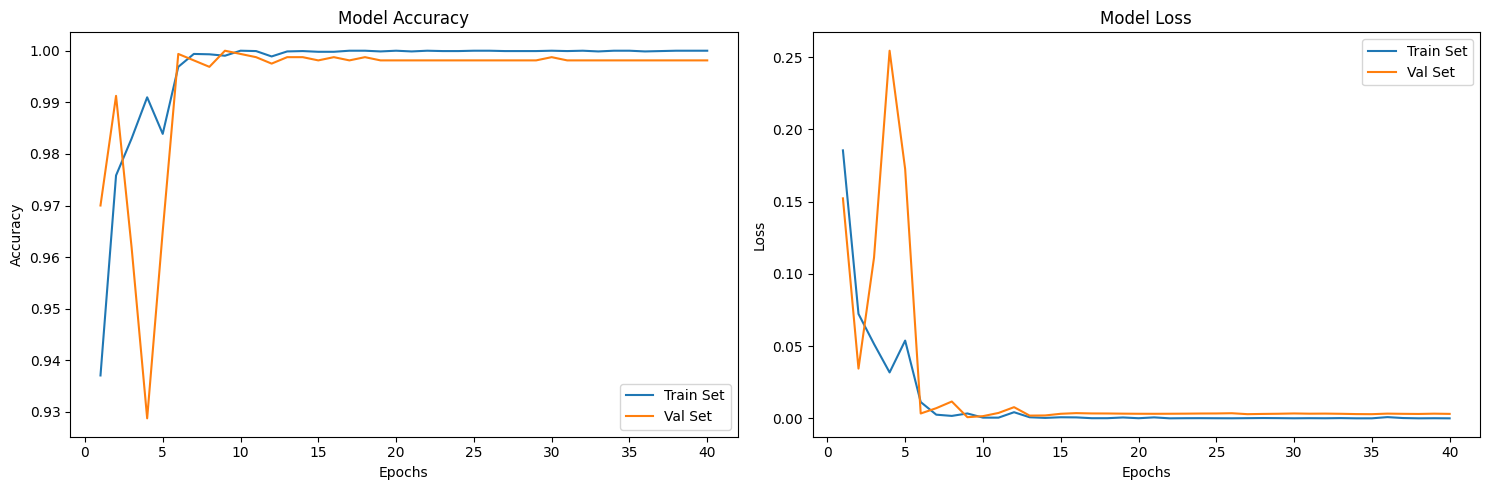

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print("Test Accuracy:", accuracy)

20/20 [==============================] - 6s 176ms/step - loss: 0.0308 - accuracy: 0.9919
Test Accuracy: 0.9918566942214966


# Experiment 6 - EfficientNetB5

In [ ]:
# Load the EfficientNetB5 model pretrained on ImageNet
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB5(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)

# Add custom layers on top of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=predictions)

# Define callbacks
tensorboard = TensorBoard(log_dir='logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/effnetb5_Aug_bestv1.h5', monitor='val_accuracy', save_best_only=True)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Train the model with the ModelCheckpoint callback
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    verbose=1,
    batch_size=32,
    callbacks=[tensorboard, reduce_lr, checkpoint]
)

115263384/115263384 [==============================] - 6s 0us/step
Epoch 1/40
450/450 [==============================] - 234s 444ms/step - loss: 0.1957 - accuracy: 0.9319 - val_loss: 0.0896 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 2/40
450/450 [==============================] - 197s 438ms/step - loss: 0.0716 - accuracy: 0.9767 - val_loss: 0.0310 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 3/40
450/450 [==============================] - 190s 423ms/step - loss: 0.0459 - accuracy: 0.9866 - val_loss: 0.0632 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 4/40
450/450 [==============================] - 192s 426ms/step - loss: 0.0570 - accuracy: 0.9817 - val_loss: 0.0659 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 5/40
450/450 [==============================] - 192s 427ms/step - loss: 0.0540 - accuracy: 0.9847 - val_loss: 0.0635 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 6/40
450/450 [==============================] - 197s 439ms/step - loss: 0.0083 - accuracy: 0.9976 - val_loss: 0.0060 - val_accuracy:

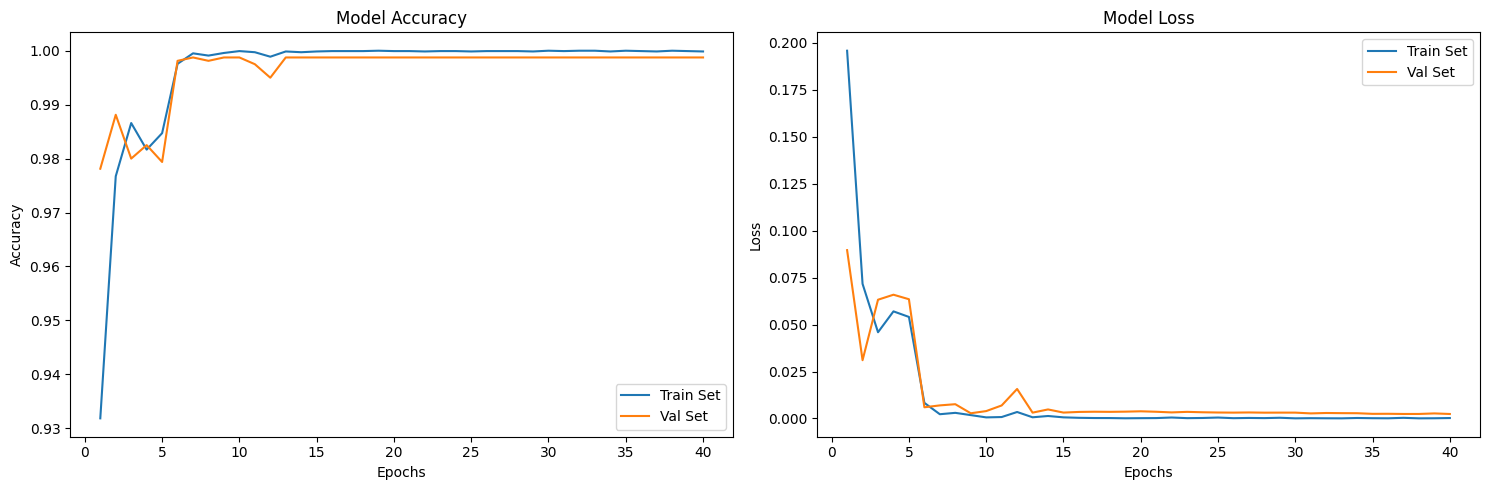

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print("Test Accuracy:", accuracy)

20/20 [==============================] - 5s 66ms/step - loss: 0.0035 - accuracy: 0.9967
Test Accuracy: 0.9967426657676697


# Experiment 7 - EfficientNetB6

In [3]:
# Load the EfficientNetB6 model pretrained on ImageNet
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB6(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)

# Add custom layers on top of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)

# Define callbacks
tensorboard = TensorBoard(log_dir='logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('effnetb6_Aug_bestv1.h5', monitor='val_accuracy', save_best_only=True)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)



165234480/165234480 [==============================] - 5s 0us/step


In [4]:
# Train the model with the ModelCheckpoint callback
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    verbose=1,
    batch_size=32,
    callbacks=[tensorboard, reduce_lr, checkpoint]
)

Epoch 1/40
450/450 [==============================] - 278s 537ms/step - loss: 0.2100 - accuracy: 0.9292 - val_loss: 0.0885 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 2/40
450/450 [==============================] - 234s 519ms/step - loss: 0.0740 - accuracy: 0.9755 - val_loss: 0.1534 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 3/40
450/450 [==============================] - 236s 524ms/step - loss: 0.0499 - accuracy: 0.9843 - val_loss: 0.0709 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 4/40
450/450 [==============================] - 233s 518ms/step - loss: 0.0449 - accuracy: 0.9842 - val_loss: 0.0355 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 5/40
450/450 [==============================] - 237s 526ms/step - loss: 0.0325 - accuracy: 0.9908 - val_loss: 0.0120 - val_accuracy: 0.9962 - lr: 0.0010
Epoch 6/40
450/450 [==============================] - 234s 520ms/step - loss: 0.0300 - accuracy: 0.9906 - val_loss: 0.0257 - val_accuracy: 0.9906 - lr: 0.0010
Epoch 7/40
450/450 [==========================

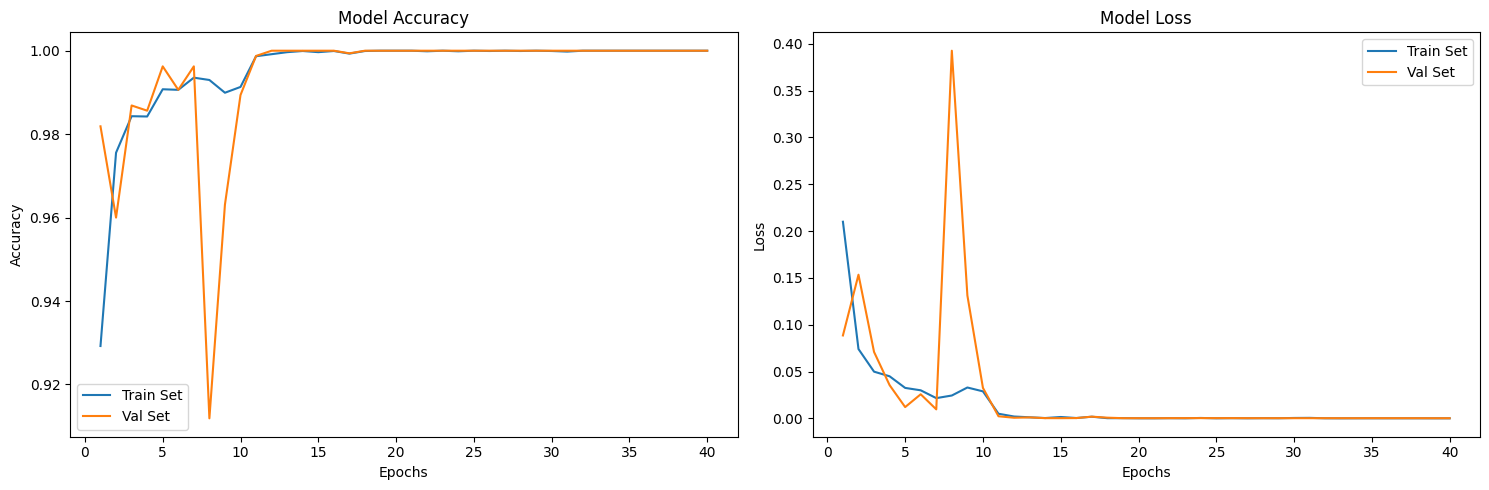

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


In [6]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print("Test Accuracy:", accuracy)

20/20 [==============================] - 6s 75ms/step - loss: 0.0344 - accuracy: 0.9886
Test Accuracy: 0.9885993599891663


# Experiment 8 - EfficientNetB7

In [8]:
# Load the EfficientNetB7 model pretrained on ImageNet
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB7(
    weights='imagenet',
    include_top=False,
    input_shape=(240, 240, 3)
)

# Add custom layers on top of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=predictions)

# Define callbacks
tensorboard = TensorBoard(log_dir='logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/effnetb7_Aug_bestv1.h5', monitor='val_accuracy', save_best_only=True)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

258076736/258076736 [==============================] - 8s 0us/step


In [9]:
# Train the model with the ModelCheckpoint callback
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=40,
    verbose=1,
    batch_size=32,
    callbacks=[tensorboard, reduce_lr, checkpoint]
)

Epoch 1/40
450/450 [==============================] - 350s 705ms/step - loss: 0.2242 - accuracy: 0.9198 - val_loss: 0.2479 - val_accuracy: 0.8963 - lr: 0.0010
Epoch 2/40
450/450 [==============================] - 320s 710ms/step - loss: 0.0835 - accuracy: 0.9727 - val_loss: 0.0974 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 3/40
450/450 [==============================] - 309s 686ms/step - loss: 0.0530 - accuracy: 0.9843 - val_loss: 0.1033 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/40
450/450 [==============================] - 308s 684ms/step - loss: 0.0420 - accuracy: 0.9860 - val_loss: 0.1213 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 5/40
450/450 [==============================] - 320s 712ms/step - loss: 0.0384 - accuracy: 0.9874 - val_loss: 0.0196 - val_accuracy: 0.9906 - lr: 0.0010
Epoch 6/40
450/450 [==============================] - 309s 687ms/step - loss: 0.0348 - accuracy: 0.9889 - val_loss: 0.2906 - val_accuracy: 0.9162 - lr: 0.0010
Epoch 7/40
450/450 [==========================

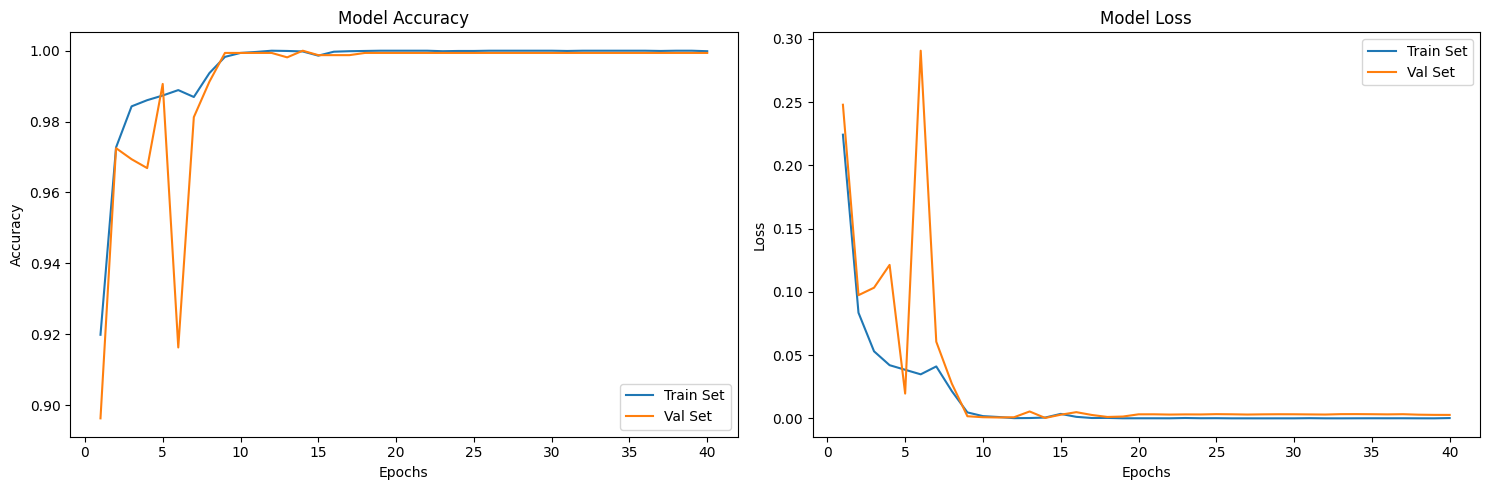

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [11]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print("Test Accuracy:", accuracy)

20/20 [==============================] - 7s 96ms/step - loss: 0.0283 - accuracy: 0.9967
Test Accuracy: 0.9967426657676697


In [7]:
import shutil

# Specify the source and destination paths
source_path = '/content/effnetb7_Aug_bestv1.h5'
destination_dir = '/content/drive/MyDrive/effnetb7_Aug_bestv1.h5'

# Move the file to the destination directory
shutil.move(source_path, destination_dir)

'/content/drive/MyDrive/effnetb6_Aug_bestv1.h5'